In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import bitstring
from qiskit_aer import AerSimulator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

In [2]:
matrix_h = ([[2**(-0.5),2**(-0.5)],[2**(-0.5),-2**(-0.5)]])
h_ideal = UnitaryGate(matrix_h)

matrix_cx = ([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
cx_ideal = UnitaryGate(matrix_cx)       #Erst Target, dann Control Qubit!!

matrix_x = ([[0,1],[1,0]])
x_ideal = UnitaryGate(matrix_x)

matrix_z = ([[1,0],[0,-1]])
z_ideal = UnitaryGate(matrix_z)

In [3]:
pre = ["11","00","23","0101"]

bits = ["1","2","3","4"]

for i in range(len(pre)):
        if pre[i].count("1") != 0:
            bits[i] = "invalid"

print(bits)

['invalid', '2', '3', 'invalid']


In [4]:
#https://stem.mitre.org/quantum/error-correction-codes/steane-ecc.htm, https://quantumcomputing.stackexchange.com/questions/28807/how-to-implement-the-circuit-of-steane-code-for-quantum-error-correction
def code(n=2):         #encodes |00>_L
    qr = QuantumRegister(7*n+1,"q")
    cbits = ClassicalRegister(7,"c")
    qc = QuantumCircuit(qr, cbits)

    for i in range(n):
        qc.h(4+7*i)
        qc.h(5+7*i)
        qc.h(6+7*i)

        qc.cx(0+7*i,1+7*i)
        qc.cx(0+7*i,2+7*i)

        qc.cx(6+7*i,0+7*i)
        qc.cx(6+7*i,1+7*i)
        qc.cx(6+7*i,3+7*i)

        qc.cx(5+7*i,0+7*i)
        qc.cx(5+7*i,2+7*i)
        qc.cx(5+7*i,3+7*i)

        qc.cx(4+7*i,1+7*i)
        qc.cx(4+7*i,2+7*i)
        qc.cx(4+7*i,3+7*i)

    return qc
#https://www.nature.com/articles/srep19578 , https://arxiv.org/pdf/1106.2190 Figure 5b)
def code_goto(n=2):             #encodes |00>_L
    qr = QuantumRegister(7*n+1,"q")
    cbits = ClassicalRegister(9+6,"c")
    qc = QuantumCircuit(qr, cbits)
    
    anc = qc.num_qubits - 1

    for i in range(n):
        # qc.h(0+7*i)                           #funktioniert auch, aber der goto code geht auch, bin bloß dumm
        # qc.h(1+7*i)
        # qc.h(3+7*i)

        # qc.cx(0+7*i,2+7*i)
        # qc.cx(3+7*i,4+7*i)

        # qc.cx(1+7*i,5+7*i)

        # qc.cx(0+7*i,6+7*i)

        # qc.cx(1+7*i,2+7*i)
        # qc.cx(3+7*i,5+7*i)

        # qc.cx(0+7*i,4+7*i)

        # qc.cx(5+7*i,6+7*i)

        # qc.cx(2+7*i,anc)
        # qc.cx(4+7*i,anc)
        # qc.cx(5+7*i,anc)

        qc.h(1+7*i)
        qc.h(2+7*i)
        qc.h(3+7*i)

        qc.cx(1+7*i,0+7*i)
        qc.cx(3+7*i,5+7*i)

        qc.cx(2+7*i,6+7*i)

        qc.cx(1+7*i,4+7*i)

        qc.cx(2+7*i,0+7*i)
        qc.cx(3+7*i,6+7*i)

        qc.cx(1+7*i,5+7*i)

        qc.cx(6+7*i,4+7*i)

        qc.cx(0+7*i,anc)
        qc.cx(5+7*i,anc)
        qc.cx(6+7*i,anc)

        qc.measure(anc,i)
        qc.reset(anc)        
    return qc

def code_goto_test(n=2):             #encodes |00>_L
    qr = QuantumRegister(7*n+1,"q")
    cbits = ClassicalRegister(9+6,"c")
    qc = QuantumCircuit(qr, cbits)
    
    anc = qc.num_qubits - 1

    for i in range(n):
        qc.append(h_ideal, [1+7*i])

        qc.append(h_ideal, [2+7*i])
        qc.append(h_ideal, [3+7*i])

        qc.append(cx_ideal, [0+7*i, 1+7*i])
        qc.append(cx_ideal, [5+7*i, 3+7*i])

        qc.append(cx_ideal, [6+7*i, 2+7*i])

        qc.append(cx_ideal, [4+7*i, 1+7*i])

        qc.append(cx_ideal, [0+7*i, 2+7*i])
        qc.append(cx_ideal, [6+7*i, 3+7*i])

        qc.append(cx_ideal, [5+7*i, 1+7*i])

        qc.append(cx_ideal, [4+7*i, 6+7*i])

        qc.append(cx_ideal, [anc, 0+7*i])
        qc.append(cx_ideal, [anc, 5+7*i])
        qc.append(cx_ideal, [anc, 6+7*i])

        qc.measure(anc,i)
        qc.reset(anc)        
    return qc

def X_L(qc: QuantumCircuit, pos: int):
    for i in range(7):
        qc.x(i+7*pos)

def Z_L(qc: QuantumCircuit, pos: int):
    for i in range(7):
        qc.z(i+7*pos)
    
def H_L(qc: QuantumCircuit, pos: int):
    for i in range(7):
        qc.h(i+7*pos)

def S_L(qc: QuantumCircuit, pos: int):
    for i in range(7):
        qc.s(i+7*pos)

def CZ_L(qc: QuantumCircuit):
    H_L(qc, 0)
    CNOT_L(qc, 1)
    H_L(qc, 0)

def adj_S_L(qc: QuantumCircuit, pos: int):
    for i in range(7):
        qc.sdg(i+7*pos)

def CNOT_L(qc: QuantumCircuit, control: int):
    if control == 0:
        for i in range(7):
            qc.cx(i, i+7)
    else:
        for i in range(7):
            qc.cx(i+7,i)

def T_L(qc: QuantumCircuit, pos: int):
    magic = qc.num_qubits - 1

    qc.append(h_ideal, [magic])
    qc.t(magic)

    for i in range(7):
        qc.cx(i+7*pos,magic)

    qc.measure(magic,magic)

    for i in range(7):
        with qc.if_test((magic,0)):
            qc.s(i+7*pos)

    qc.reset(magic)

def adj_T_L(qc: QuantumCircuit, pos: int):
    magic = qc.num_qubits - 1

    qc.append(h_ideal, [magic])
    qc.tdg(magic)

    for i in range(7):
        qc.cx(i+7*pos,magic)

    qc.measure(magic,magic)

    for i in range(7):
        with qc.if_test((magic,0)):
            qc.sdg(i+7*pos)

    qc.reset(magic)

def CS_L(qc: QuantumCircuit, control: int, target: int):
    T_L(qc, 0)
    T_L(qc, 1)
    CNOT_L(qc, control=control)
    adj_T_L(qc, pos = target)
    CNOT_L(qc, control=control)

def readout(qc: QuantumCircuit, pos: int, shots: int, noise = 0):
    p = noise
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XX",p/6],["XI",p/6],["IX",p/6],["II",1-p],["ZZ",p/6],["ZI",p/6],["IZ",p/6]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "s", "sdg"])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

    # depolarizing_prob = noise
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)

    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h',"s","sdg"])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates
    
    if pos == 0:
        for i in range(7):
            qc.measure(i,14-i)
    elif pos == 1:
        for i in range(7):
            qc.measure(7+i,14-i)

    sim = AerSimulator()
    
    job = sim.run(qc, shots=shots, noise_model=noise_model)

    result = job.result()
    counts = result.get_counts()

    bitstring = list(counts.keys())
    hmm = list(counts.values())

    pre, preselected = [i[13:] for i in bitstring], 0
    bits = [i[:7] for i in bitstring]
    #stab = [i[7:13] for i in bitstring]

    #print(pre)
    #print(bits)
    #print(stab)

    for i in range(len(pre)):
        if pre[i].count("1") != 0:
            bits[i] = "pre"
            preselected += hmm[i]

    test_0 = ["0000000","1010101","0110011","1100110","0001111","1011010","0111100","1101001"]
    test_1 = ["1111111","0101010","1001100","0011001","1110000","0100101","1000011","0010110"]

    for i in range(len(bits)):
        for j in test_0:
            if j == bits[i]:
                bits[i] = 0
                break
        if bits[i] != 0:
            for j in test_1:
                if j == bits[i]:
                    bits[i] = 1
                    break
        if bits[i] != 1 and bits[i] != 0 and bits[i] != "pre":
            bits[i] = "post"

    ones = 0
    zeros = 0
    post = 0

    for i in range(len(bits)):
        if bits[i] == 0:
            zeros += hmm[i]
        if bits[i] == 1:
            ones += hmm[i]
        if bits[i] == "post":
            post += hmm[i]
    
    ones = (ones/shots)
    zeros = (zeros/shots)
    post = (post/shots)
    preselected = (preselected/shots)

    # print("0: ", zeros, "%")
    # print("1: ", ones, "%")
    # print("Preselection discarded: ", (preselected/shots)*100, "%")
    # print("Postselection discarded: ", err - (preselected/shots)*100, "%")
    return zeros, ones, preselected, post

def qec(qc: QuantumCircuit, pos: int):
    anc = qc.num_qubits - 1
    qc.reset(anc)
    ##################################Z-Stabilizers##########################################
    qc.cx(0+7*pos, anc)
    qc.cx(2+7*pos, anc)
    qc.cx(4+7*pos, anc)
    qc.cx(6+7*pos, anc)

    qc.measure(anc, 2)
    qc.reset(anc)

    qc.cx(1+7*pos, anc)
    qc.cx(2+7*pos, anc)
    qc.cx(5+7*pos, anc)
    qc.cx(6+7*pos, anc)

    qc.measure(anc, 1)
    qc.reset(anc)

    qc.cx(3+7*pos, anc)
    qc.cx(4+7*pos, anc)
    qc.cx(5+7*pos, anc)
    qc.cx(6+7*pos, anc)

    qc.measure(anc, 0)
    qc.reset(anc)
    ##################################X-Stabilizers##############################################
    qc.h(anc)
    qc.cx(anc, 0+7*pos)
    qc.cx(anc, 2+7*pos)
    qc.cx(anc, 4+7*pos)
    qc.cx(anc, 6+7*pos)
    qc.h(anc)

    qc.measure(anc, 5)
    qc.reset(anc)

    qc.h(anc)
    qc.cx(anc, 1+7*pos)
    qc.cx(anc, 2+7*pos)
    qc.cx(anc, 5+7*pos)
    qc.cx(anc, 6+7*pos)
    qc.h(anc)

    qc.measure(anc, 4)
    qc.reset(anc)

    qc.h(anc)
    qc.cx(anc, 3+7*pos)
    qc.cx(anc, 4+7*pos)
    qc.cx(anc, 5+7*pos)
    qc.cx(anc, 6+7*pos)
    qc.h(anc)

    qc.measure(anc, 3)
    qc.reset(anc)
    ##################################Bitflip Error correction##############################################
    
    with qc.if_test((0,0)):             #qbit 0
        with qc.if_test((1,0)):
            with qc.if_test((2,1)):
                qc.x(0+7*pos)

    with qc.if_test((0,0)):             #qbit 1
        with qc.if_test((1,1)):
            with qc.if_test((2,0)):
                qc.x(1+7*pos)
    
    with qc.if_test((0,0)):             #qbit 2
        with qc.if_test((1,1)):
            with qc.if_test((2,1)):
                qc.x(2+7*pos)
    
    with qc.if_test((0,1)):             #qbit 3
        with qc.if_test((1,0)):
            with qc.if_test((2,0)):
                qc.x(3+7*pos)
    
    with qc.if_test((0,1)):             #qbit 4
        with qc.if_test((1,0)):
            with qc.if_test((2,1)):
                qc.x(4+7*pos)
    
    with qc.if_test((0,1)):             #qbit 5
        with qc.if_test((1,1)):
            with qc.if_test((2,0)):
                qc.x(5+7*pos)
    
    with qc.if_test((0,1)):             #qbit 6
        with qc.if_test((1,1)):
            with qc.if_test((2,1)):
                qc.x(6+7*pos)

    ##################################Phaseflip Error correction##############################################
    
    with qc.if_test((3,0)):             #qbit 0
        with qc.if_test((4,0)):
            with qc.if_test((5,1)):
                qc.z(0+7*pos)

    with qc.if_test((3,0)):             #qbit 1
        with qc.if_test((4,1)):
            with qc.if_test((5,0)):
                qc.z(1+7*pos)
    
    with qc.if_test((3,0)):             #qbit 2
        with qc.if_test((4,1)):
            with qc.if_test((5,1)):
                qc.z(2+7*pos)
    
    with qc.if_test((3,1)):             #qbit 3
        with qc.if_test((4,0)):
            with qc.if_test((5,0)):
                qc.z(3+7*pos)
    
    with qc.if_test((3,1)):             #qbit 4
        with qc.if_test((4,0)):
            with qc.if_test((5,1)):
                qc.z(4+7*pos)
    
    with qc.if_test((3,1)):             #qbit 5
        with qc.if_test((4,1)):
            with qc.if_test((5,0)):
                qc.z(5+7*pos)
    
    with qc.if_test((3,1)):             #qbit 6
        with qc.if_test((4,1)):
            with qc.if_test((5,1)):
                qc.z(6+7*pos)

def qec_ideal(qc: QuantumCircuit, pos: int):
    anc = qc.num_qubits - 1
    qc.reset(anc)
    ##################################Z-Stabilizers##########################################
    qc.append(cx_ideal, [anc, 0+7*pos])
    qc.append(cx_ideal, [anc, 2+7*pos])
    qc.append(cx_ideal, [anc, 4+7*pos])
    qc.append(cx_ideal, [anc, 6+7*pos])

    qc.measure(anc, 4)
    qc.reset(anc)

    qc.append(cx_ideal, [anc, 1+7*pos])
    qc.append(cx_ideal, [anc, 2+7*pos])
    qc.append(cx_ideal, [anc, 5+7*pos])
    qc.append(cx_ideal, [anc, 6+7*pos])

    qc.measure(anc, 3)
    qc.reset(anc)

    qc.append(cx_ideal, [anc, 3+7*pos])
    qc.append(cx_ideal, [anc, 4+7*pos])
    qc.append(cx_ideal, [anc, 5+7*pos])
    qc.append(cx_ideal, [anc, 6+7*pos])

    qc.measure(anc, 2)
    qc.reset(anc)
    ##################################Bitflip Error correction##############################################
    
    with qc.if_test((2,0)):             #qbit 0
        with qc.if_test((3,0)):
            with qc.if_test((4,1)):
                qc.append(x_ideal,[0+7*pos])

    with qc.if_test((2,0)):             #qbit 1
        with qc.if_test((3,1)):
            with qc.if_test((4,0)):
                qc.append(x_ideal,[1+7*pos])
    
    with qc.if_test((2,0)):             #qbit 2
        with qc.if_test((3,1)):
            with qc.if_test((4,1)):
                qc.append(x_ideal,[2+7*pos])
    
    with qc.if_test((2,1)):             #qbit 3
        with qc.if_test((3,0)):
            with qc.if_test((4,0)):
                qc.append(x_ideal,[3+7*pos])
    
    with qc.if_test((2,1)):             #qbit 4
        with qc.if_test((3,0)):
            with qc.if_test((4,1)):
                qc.append(x_ideal,[4+7*pos])
    
    with qc.if_test((2,1)):             #qbit 5
        with qc.if_test((3,1)):
            with qc.if_test((4,0)):
                qc.append(x_ideal,[5+7*pos])
    
    with qc.if_test((2,1)):             #qbit 6
        with qc.if_test((3,1)):
            with qc.if_test((4,1)):
                qc.append(x_ideal,[6+7*pos])

    ##################################X-Stabilizers##############################################
    qc.append(h_ideal, [anc])
    qc.append(cx_ideal, [0+7*pos, anc])
    qc.append(cx_ideal, [2+7*pos, anc])
    qc.append(cx_ideal, [4+7*pos, anc])
    qc.append(cx_ideal, [6+7*pos, anc])
    qc.append(h_ideal, [anc])

    qc.measure(anc, 7)
    qc.reset(anc)

    qc.append(h_ideal, [anc])
    qc.append(cx_ideal, [1+7*pos, anc])
    qc.append(cx_ideal, [2+7*pos, anc])
    qc.append(cx_ideal, [5+7*pos, anc])
    qc.append(cx_ideal, [6+7*pos, anc])
    qc.append(h_ideal, [anc])

    qc.measure(anc, 6)
    qc.reset(anc)

    qc.append(h_ideal, [anc])
    qc.append(cx_ideal, [3+7*pos, anc])
    qc.append(cx_ideal, [4+7*pos, anc])
    qc.append(cx_ideal, [5+7*pos, anc])
    qc.append(cx_ideal, [6+7*pos, anc])
    qc.append(h_ideal, [anc])

    qc.measure(anc, 5)
    qc.reset(anc)
    ##################################Phaseflip Error correction##############################################
    
    with qc.if_test((5,0)):             #qbit 0
        with qc.if_test((6,0)):
            with qc.if_test((7,1)):
                qc.append(z_ideal,[0+7*pos])

    with qc.if_test((5,0)):             #qbit 1
        with qc.if_test((6,1)):
            with qc.if_test((7,0)):
                qc.append(z_ideal,[1+7*pos])
    
    with qc.if_test((5,0)):             #qbit 2
        with qc.if_test((6,1)):
            with qc.if_test((7,1)):
                qc.append(z_ideal,[2+7*pos])
    
    with qc.if_test((5,1)):             #qbit 3
        with qc.if_test((6,0)):
            with qc.if_test((7,0)):
                qc.append(z_ideal,[3+7*pos])
    
    with qc.if_test((5,1)):             #qbit 4
        with qc.if_test((6,0)):
            with qc.if_test((7,1)):
                qc.append(z_ideal,[4+7*pos])
    
    with qc.if_test((5,1)):             #qbit 5
        with qc.if_test((6,1)):
            with qc.if_test((7,0)):
                qc.append(z_ideal,[5+7*pos])
    
    with qc.if_test((5,1)):             #qbit 6
        with qc.if_test((6,1)):
            with qc.if_test((7,1)):
                qc.append(z_ideal,[6+7*pos])
    

In [25]:
qc = code_goto()
qec_ideal(qc, 0)

X_L(qc,0)
qec_ideal(qc, 0)
X_L(qc,0)
qec_ideal(qc, 0)
X_L(qc,0)
qec_ideal(qc, 0)

shots = 100
zeros, ones, pre, post = readout(qc, 0, shots, 0.1)


print("Preselection discarded: ", pre*100, "%")
print("Postselection discarded: ", post*100, "%")
print("Accepted 0: ", zeros*100, "%")
print("Accepted 1: ", ones*100, "%")
print("Total discarded: ", (pre+post)*100, "%")
print("Succesrate: ", ones/(ones+zeros))

#qc.draw("mpl")

Preselection discarded:  46.72 %
Postselection discarded:  0.0 %
Accepted 0:  7.5 %
Accepted 1:  45.78 %
Total discarded:  46.72 %
Succesrate:  0.8592342342342343


In [13]:
#iQPE first iteration

qc = code_goto()

qec_ideal(qc,0)
qec_ideal(qc,1)

X_L(qc,1)
qec_ideal(qc,1)

H_L(qc,0)
qec_ideal(qc,0)

H_L(qc, 0)
qec_ideal(qc,0)
CNOT_L(qc, 1)
qec_ideal(qc,0)
qec_ideal(qc,1)
H_L(qc, 0)
qec_ideal(qc,0)

H_L(qc,0)
qec_ideal(qc,0)

shots = 1000
zeros, ones, pre, post = readout(qc, 0, shots, 0.1)


print("Preselection discarded: ", pre*100, "%")
print("Postselection discarded: ", post*100, "%")
print("Accepted 0: ", zeros*100, "%")
print("Accepted 1: ", ones*100, "%")
print("Total discarded: ", (pre+post)*100, "%")
print("Succesrate: ", ones/(ones+zeros))

Preselection discarded:  46.300000000000004 %
Postselection discarded:  0.0 %
Accepted 0:  11.600000000000001 %
Accepted 1:  42.1 %
Total discarded:  46.300000000000004 %
Succesrate:  0.7839851024208565


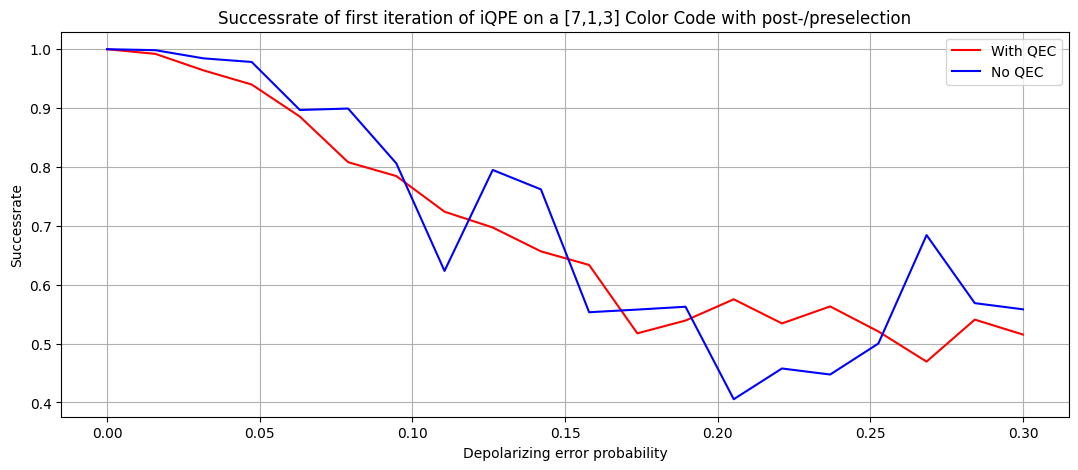

In [6]:
x = np.linspace(0,0.3,20)
y = []
y_no_QEC = []
one, zero, one_QEC, zero_QEC, pre, post, pre_QEC, post_QEC = [],[],[],[],[],[],[],[]
shots = 10000
for i in x:
    # depolarizing_prob = i
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)
    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h'])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates
    
    qc = code_goto()

    X_L(qc,1)

    H_L(qc,0)

    CZ_L(qc)

    H_L(qc,0)

    #CNOT_L(qc,1)

    zeros, ones, preselec , postselec = readout(qc, 0, shots, i)

    total = zeros + ones

    y_no_QEC.append(ones/total)

    pre.append(preselec), post.append(postselec), one.append(ones), zero.append(zeros)

    ###############################################################################################################

    qc = code_goto()
    qec_ideal(qc, 0)
    qec_ideal(qc, 1)

    X_L(qc,1)
    qec_ideal(qc, 1)

    H_L(qc,0)
    qec_ideal(qc, 0)

    H_L(qc, 0)
    qec_ideal(qc,0)
    CNOT_L(qc, 1)
    qec_ideal(qc,1)
    H_L(qc, 0)
    qec_ideal(qc,0)

    H_L(qc,0)
    qec_ideal(qc, 0)

    zeros, ones, preselec , postselec = readout(qc, 0, shots, i)

    total = zeros + ones

    y.append(ones/total)
    pre_QEC.append(preselec), post_QEC.append(postselec), one_QEC.append(ones), zero_QEC.append(zeros)

data = np.array((x,pre,post,zero,one,pre_QEC,post_QEC, zero_QEC, one_QEC))
np.savetxt("Plots/text/Steane_1st_pauli_10k.txt", data, delimiter=",")

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red")
ax.plot(x,y_no_QEC,label = "No QEC", color="blue")
plt.title("Successrate of first iteration of iQPE on a [7,1,3] Color Code with post-/preselection")
plt.xlabel("Depolarizing error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()

In [34]:
#iQPE second iteration                  # p=5%, 10k Shots:    no qec: 70% Success, mit qec: Success

qc = code_goto()
#qec_ideal(qc,1)
#qec_ideal(qc,0)

X_L(qc,1)
#qec_ideal(qc,1)

H_L(qc,0)
#qec_ideal(qc,0)

T_L(qc, 0)
#qec_ideal(qc,0)

T_L(qc, 1)
#qec_ideal(qc,1)

CNOT_L(qc, control=0)
#qec_ideal(qc,1)
#qec_ideal(qc,0)

adj_T_L(qc, pos = 1)
#qec_ideal(qc,1)

CNOT_L(qc, control=0)
#qec_ideal(qc,1)
#qec_ideal(qc,0)

adj_S_L(qc, 0)
#qec_ideal(qc,0)

H_L(qc, 0)
#qec_ideal(qc,0)

zeros, ones, err, preselected = readout(qc, 0, 10000, 0.1)

print("Preselection discarded: ", preselected, "%")
print("Postselection discarded: ", err - preselected, "%")
print("0: ", zeros, "%")
print("1: ", ones, "%")
print("Pre-/Postselection discarded: ", err, "%")
print("Succesrate: ", zeros/(ones+zeros)*100, "%")

Preselection discarded:  56.88999999999999 %
Postselection discarded:  37.35 %
0:  2.96 %
1:  2.8000000000000003 %
Pre-/Postselection discarded:  94.24 %
Succesrate:  51.38888888888889 %


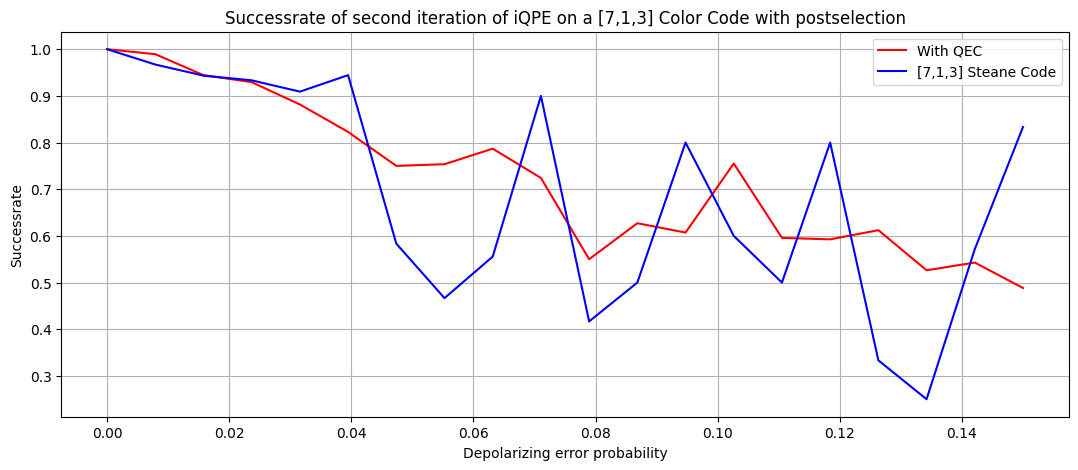

In [ ]:
x = np.linspace(0,0.15,20)
y = []
y_no_QEC = []
one, zero, one_QEC, zero_QEC, pre, post, pre_QEC, post_QEC = [],[],[],[],[],[],[],[]
shots = 100
for i in x:
    # depolarizing_prob = i
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)
    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h'])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates
    
    qc = code_goto()

    X_L(qc,1)

    H_L(qc,0)

    CS_L(qc, 1, 0)

    adj_S_L(qc, 0)

    H_L(qc, 0)

    zeros, ones, preselec , postselec = readout(qc, 0, shots, i)

    total = zeros + ones

    y_no_QEC.append(zeros/total)
    pre.append(preselec), post.append(postselec), one.append(ones), zero.append(zeros)
    ###################################################################################################
    qc = code_goto()
    qec_ideal(qc,0)
    qec_ideal(qc,1)

    X_L(qc,1)
    qec_ideal(qc,1)

    H_L(qc,0)
    qec_ideal(qc,0)

    T_L(qc, 0)
    qec_ideal(qc,0)
    T_L(qc, 1)
    qec_ideal(qc,1)
    CNOT_L(qc, control=0)
    qec_ideal(qc,0)
    qec_ideal(qc,1)
    adj_T_L(qc, pos = 1)
    qec_ideal(qc,1)
    CNOT_L(qc, control=0)
    qec_ideal(qc,1)
    qec_ideal(qc,0)

    adj_S_L(qc, 0)
    qec_ideal(qc,0)

    H_L(qc, 0)
    qec_ideal(qc,0)

    zeros, ones, preselec , postselec = readout(qc, 0, shots, i)

    total = zeros + ones

    y.append(zeros/total)
    pre_QEC.append(preselec), post_QEC.append(postselec), one_QEC.append(ones), zero_QEC.append(zeros)

data = np.array((x,pre,post,zero,one,pre_QEC,post_QEC, zero_QEC, one_QEC))
np.savetxt("Plots/text/Steane_2nd_Pauli_5k.txt", data, delimiter=",")

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red")
ax.plot(x,y_no_QEC, label = "[7,1,3] Steane Code", color="blue")
plt.title("Successrate of second iteration of iQPE on a [7,1,3] Color Code with postselection")
plt.xlabel("Depolarizing error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()